# **v2.0 GraphSAGE Architecture with 1 hidden layer**

nodes: raw coordinates
edges: integration2km, nodecount2km, road class

- still as extremely low r2 value, means that the model is not able to find a suitable relationship to predict the edge weights.
- this is even after checks that the train-test split is relatively evenly distributed.
- realization that graphSAGE architecture does not fully support the evaluation of edge weights.

**Import pytorch geometric**

In [1]:
#!pip install torch torchvision torchaudio
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.1.0+cpu.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cpu.html
  Using cached torch_scatter-2.1.2.tar.gz (108 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached torch_sparse-0.6.18.tar.gz (209 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached torch_cluster-1.6.3.tar.gz (54 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached torch_spline_conv-1.2.2.tar.gz (25 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for torch-scatter
  Running setup.py clean for torch-sparse
  Running setup.py clean for torch-cluster
  Running setup.py clean for torch-spline-conv
Failed to build torch-scatter torch-sparse torch-cluster torch-spline-conv


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [31 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd64-cpython-312\torch_scatter
      copying torch_scatter\placeholder.py -> build\lib.win-amd64-cpython-312\torch_scatter
      copying torch_scatter\scatter.py -> build\lib.win-amd64-cpython-312\torch_scatter
      copying torch_scatter\segment_coo.py -> build\lib.win-amd64-cpython-312\torch_scatter
      copying torch_scatter\segment_csr.py -> build\lib.win-amd64-cpython-312\torch_scatter
      copying torch_scatter\testing.py -> build\lib.win-amd64-cpython-312\torch_scatter
      copying torch_scatter\utils.py -> build\lib.win-amd64-cpython-312\torch_scatter
      copying torch_scatter\__init__.py -> build\lib.win-amd64-cpython-312\torch_scatter
      creating build\lib.win-amd64-cpython-312\torch_scatter\composite
      copying torch_scatter\c

##**Create London dataset**

In [2]:
#importing drive and os libraries
#from google.colab import drive
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#mounting google drive
#Edrive.mount('/content/drive', force_remount=True)



In [48]:
#giving the directory of the files
path = "C:/Users/chalm/Documents/Sem 2/Computational Intelligence/SpaceSyntax_UK/csv/" # Corrected path to the directory
# using chdir for changing the directory to the path we look for
os.chdir(path)

#reading a comma-separated values (csv) file into DataFrame
df = pd.read_csv("Birmingham.csv")

**Data Anlaysis for relationships**

In [49]:
df.head()

,id,metres,meridian_id,meridian_gid,meridian_code,meridian_osodr,meridian_number,meridian_road_name,meridian_indicator,meridian_class,...,wz11cd,lsoa11cd,lsoa11nm,msoa11cd,msoa11nm,lad11cd,lad11nm,meridian_class_scale,wkt,geometry
0,116894,36.891733,821537,534450,3004,O169VNPBNALAW,NaN,DEEPWOOD GROVE,NaN,minor,...,E33020382,E01008923,Birmingham 102B,E02001928,Birmingham 102,E08000025,Birmingham,1,"LINESTRING(399984 281923,399953 281943)","LINESTRING (399984 281923, 399953 281943)"
1,116895,37.121422,821537,534450,3004,O169VNPBNALAW,NaN,DEEPWOOD GROVE,NaN,minor,...,E33020382,E01008923,Birmingham 102B,E02001928,Birmingham 102,E08000025,Birmingham,1,"LINESTRING(399953 281943,399990 281940)","LINESTRING (399953 281943, 399990 281940)"
2,113868,27.802878,820257,530813,3004,O169VQ5BQHEAW,NaN,CHEVELEY AVENUE,NaN,minor,...,E33020472,E01009167,Birmingham 130C,E02001956,Birmingham 130,E08000025,Birmingham,1,"LINESTRING(399870 277371,399848 277354)","LINESTRING (399870 277371, 399848 277354)"
3,113054,461.278658,819631,70697,3001,O169VD3BQG4AW,A38,BRISTOL ROAD SOUTH,NaN,aroad,...,E33020469,E01009165,Birmingham 129C,E02001955,Birmingham 129,E08000025,Birmingham,3,"LINESTRING(400343 277539,400796 277452)","LINESTRING (400343 277539, 400796 277452)"
4,113055,98.005102,819632,70699,3001,O169VJGUQFBTW,A38,BRISTOL ROAD SOUTH,NaN,aroad,...,E33020469,E01009165,Birmingham 129C,E02001955,Birmingham 129,E08000025,Birmingham,3,"LINESTRING(400173 277544,400271 277545)","LINESTRING (400173 277544, 400271 277545)"


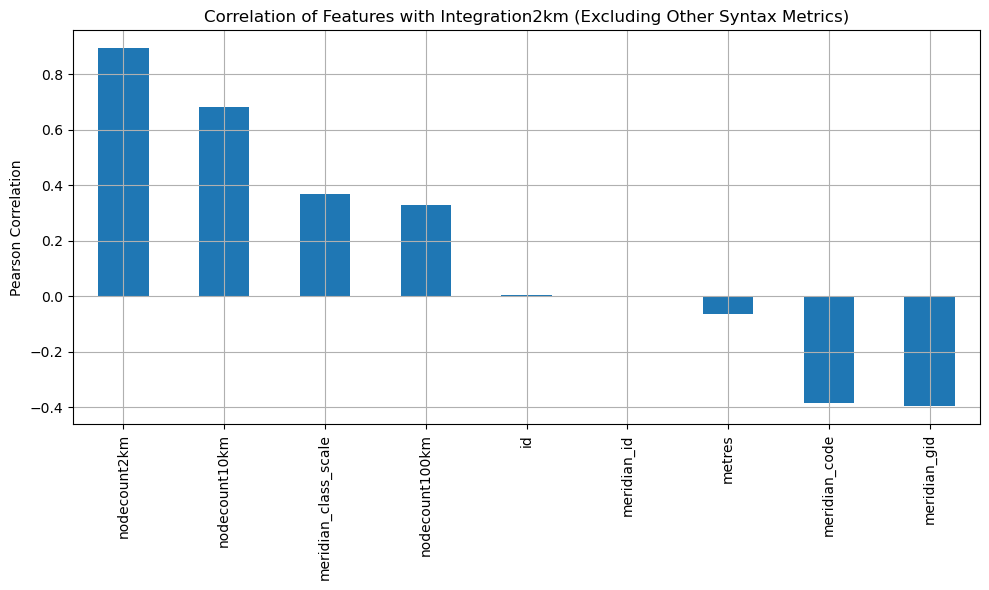

nodecount2km            0.894424
nodecount10km           0.684134
meridian_class_scale    0.368816
nodecount100km          0.330244
id                      0.005576
meridian_id            -0.002969
metres                 -0.063320
meridian_code          -0.384749
meridian_gid           -0.397306
Name: integration2km, dtype: float64

In [50]:
# Drop the columns that are disallowed (choice*, integration100km, etc.)
excluded_keywords = ['choice', 'integration100km', 'integration10km', 'rank']
columns_to_include = [col for col in df.columns if not any(key in col.lower() for key in excluded_keywords)]

# Filter dataframe
filtered_df = df[columns_to_include]

# Now select only numerical columns for correlation analysis
numerical_df = filtered_df.select_dtypes(include='number')

# Compute correlation with integration2km
correlation_with_target = numerical_df.corr()['integration2km'].drop('integration2km').sort_values(ascending=False)

# Plotting the correlations
plt.figure(figsize=(10, 6))
correlation_with_target.plot(kind='bar')
plt.title('Correlation of Features with Integration2km (Excluding Other Syntax Metrics)')
plt.ylabel('Pearson Correlation')
plt.grid(True)
plt.tight_layout()
plt.show()

# Also show the correlation values directly for analysis
correlation_with_target


**Prepare syntax graph for GNN tensors**

In [6]:
import torch
from torch_geometric.data import Data


In [59]:
from shapely import wkt
from sklearn.preprocessing import MinMaxScaler


# Convert geometry WKT column to GeoSeries
gs = gpd.GeoSeries.from_wkt(df['wkt'])

# Create a proper GeoDataFrame (CRS optional but recommended)
london_gdf = gpd.GeoDataFrame(df, geometry=gs, crs="EPSG:27700")

london_gdf['src_coord'] = london_gdf['geometry'].apply(lambda g: (g.coords[0][0], g.coords[0][1]))
london_gdf['dst_coord'] = london_gdf['geometry'].apply(lambda g: (g.coords[-1][0], g.coords[-1][1]))

# 2. Assign each unique coordinate an integer node ID
unique_coords = pd.Series(pd.concat([london_gdf['src_coord'], london_gdf['dst_coord']]).unique())
coord_to_node = {coord: i for i, coord in enumerate(unique_coords)}

# 3. Build edge index
src_nodes = london_gdf['src_coord'].map(coord_to_node).tolist()
dst_nodes = london_gdf['dst_coord'].map(coord_to_node).tolist()
edge_index = torch.tensor([src_nodes, dst_nodes], dtype=torch.long)

# 4. Extract edge weights
edge_weights = torch.tensor(london_gdf['integration2km'].values, dtype=torch.float)

#add in nodecount2km and meridian_class_scale as additional features
edge_attr = torch.tensor(
    london_gdf[['integration2km','nodecount2km', 'meridian_class_scale']].values,
    dtype=torch.float
)

# 5. Build node features — we'll use raw coordinates for now
node_coords = torch.tensor([list(coord) for coord in unique_coords], dtype=torch.float)
node_features = node_coords  # 2D coordinate features

# Summary
num_nodes = node_features.shape[0]
num_edges = edge_index.shape[1]

num_nodes, num_edges


data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, y=edge_weights)



**Create GNN class**

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# ----------------------------
# ✅ Regularized GNN Model
# ----------------------------
class EdgeWeightGNN(nn.Module):
    def __init__(self, in_channels, hidden1, embedding_dim, dropout_prob=0.3):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden1)
        self.bn1 = nn.BatchNorm1d(hidden1)
        self.dropout = nn.Dropout(dropout_prob)
        self.conv2 = GCNConv(hidden1, embedding_dim)

        self.edge_mlp = nn.Sequential(
            nn.Linear(embedding_dim * 2, 32),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(32, 1)
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)

        src, dst = edge_index
        edge_repr = torch.cat([x[src], x[dst]], dim=1)
        edge_pred = self.edge_mlp(edge_repr).squeeze()

        return edge_pred, x



**Create GraphSAGE class**

In [60]:
class EdgeRegressionGraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, embedding_dim):
        super().__init__()
        self.sage1 = SAGEConv(in_channels, hidden1)
        self.sage2 = SAGEConv(hidden1, hidden2)
        self.sage3 = SAGEConv(hidden2, embedding_dim)
        self.edge_mlp = nn.Sequential(
            nn.Linear(embedding_dim * 2, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.sage1(x, edge_index))
        x = F.relu(self.sage2(x, edge_index))
        x = self.sage3(x, edge_index)

        src, dst = edge_index
        edge_repr = torch.cat([x[src], x[dst]], dim=1)
        edge_pred = self.edge_mlp(edge_repr).squeeze()
        return edge_pred, x


##**Train**

In [61]:
# ----------------------------
# ✅ Train/Test Split
# ----------------------------

# Shuffle edge indices before training
perm = torch.randperm(edge_index.shape[1])
edge_index = edge_index[:, perm]
edge_weights = edge_weights[perm]

num_edges = edge_index.shape[1]
num_train = int(0.8 * num_edges)

train_edge_index = edge_index[:, :num_train]
train_edge_weights = edge_weights[:num_train]
test_edge_index = edge_index[:, num_train:]
test_edge_weights = edge_weights[num_train:]

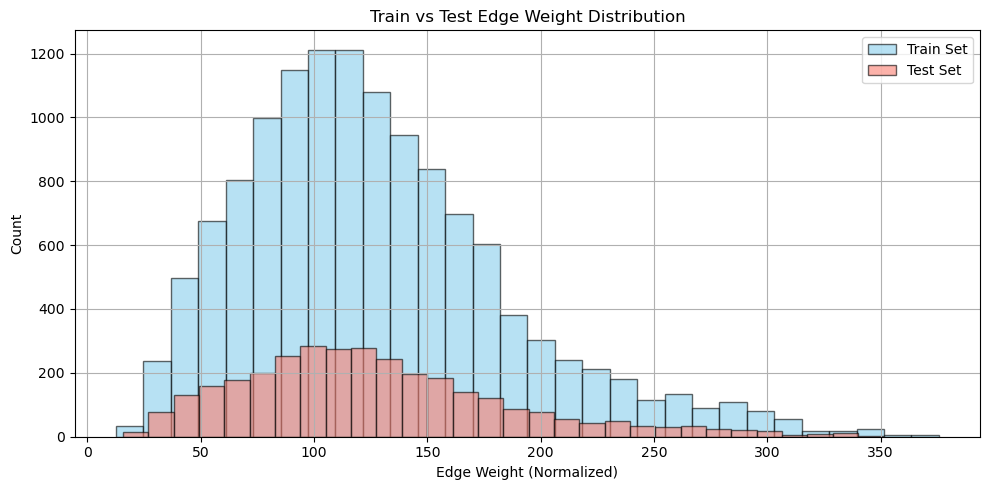

In [55]:
import matplotlib.pyplot as plt

# Plot the edge weight distributions in train vs test splits
plt.figure(figsize=(10, 5))

plt.hist(train_edge_weights.numpy(), bins=30, alpha=0.6, label='Train Set', color='skyblue', edgecolor='black')
plt.hist(test_edge_weights.numpy(), bins=30, alpha=0.6, label='Test Set', color='salmon', edgecolor='black')

plt.title("Train vs Test Edge Weight Distribution")
plt.xlabel("Edge Weight (Normalized)")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch   0 | Train Loss: 107815496.0000 | Val Loss: 2222459648.0000
Epoch  25 | Train Loss: 12860389.0000 | Val Loss: 4328189.5000
Epoch  50 | Train Loss: 666999.5625 | Val Loss: 590496.6250
Epoch  75 | Train Loss: 86758.1797 | Val Loss: 18098.0508
Epoch 100 | Train Loss: 18290.3613 | Val Loss: 11740.9902
Epoch 125 | Train Loss: 10758.0439 | Val Loss: 9064.9521
Epoch 150 | Train Loss: 5753.0840 | Val Loss: 4941.0576
Epoch 175 | Train Loss: 5615.4990 | Val Loss: 5038.5127
Epoch 200 | Train Loss: 5298.4463 | Val Loss: 4650.4175
Epoch 225 | Train Loss: 5200.6909 | Val Loss: 4698.8032
Epoch 250 | Train Loss: 5122.7915 | Val Loss: 4669.4917
Epoch 275 | Train Loss: 5036.3940 | Val Loss: 4634.9526
Epoch 299 | Train Loss: 4945.6807 | Val Loss: 4605.0229


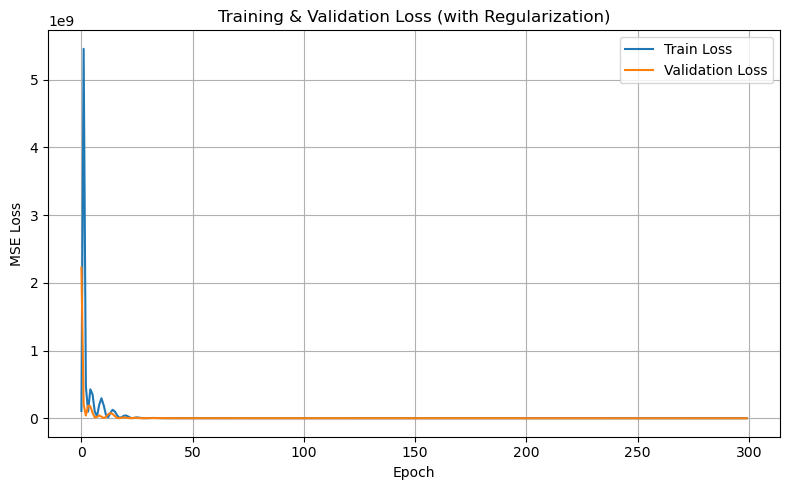

In [62]:

# ----------------------------
# ✅ Model Setup
# ----------------------------
#model = EdgeWeightGNN(in_channels=2, hidden1=16, embedding_dim=8, dropout_prob=0.3)

model = EdgeRegressionGraphSAGE(
    in_channels=node_features.shape[1],
    hidden1=16,
    hidden2=12,
    embedding_dim=8
)


optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.MSELoss()

train_loss_history = []
val_loss_history = []

# ----------------------------
# ✅ Training Loop
# ----------------------------
for epoch in range(300):
    model.train()
    optimizer.zero_grad()
    
    data.edge_index = train_edge_index
    train_pred, _ = model(data)
    train_loss = loss_fn(train_pred, train_edge_weights)
    train_loss.backward()
    optimizer.step()
    train_loss_history.append(train_loss.item())

    model.eval()
    with torch.no_grad():
        data.edge_index = test_edge_index
        val_pred, _ = model(data)
        val_loss = loss_fn(val_pred, test_edge_weights)
        val_loss_history.append(val_loss.item())

    if epoch % 25 == 0 or epoch == 299:
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

# ----------------------------
# ✅ Loss Plot
# ----------------------------
plt.figure(figsize=(8, 5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title("Training & Validation Loss (with Regularization)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Regression evaluation metrics**

**MAE** — How far off the predictions are on average.

**MSE** — Penalizes large errors more heavily.

**RMSE** — Same as MSE but in the same units as the target.

**R² Score** — Indicates how well the model explains the variance in the data (1 = perfect prediction, 0 = mean predictor).

##**Visualize output**

In [63]:
# Evaluation
model.eval()
with torch.no_grad():
    data.edge_index = test_edge_index  # Only predict on test edges
    test_pred_weights, node_emb = model(data)
    test_pred = test_pred_weights.detach().numpy()
    test_truth = test_edge_weights.numpy()

    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

    mae = mean_absolute_error(test_truth, test_pred)
    mse = mean_squared_error(test_truth, test_pred)
    rmse = mse ** 0.5
    r2 = r2_score(test_truth, test_pred)

    print("📊 Evaluation Metrics on Test Set:")
    print(f"MAE  (Mean Absolute Error)      : {mae:.4f}")
    print(f"MSE  (Mean Squared Error)       : {mse:.4f}")
    print(f"RMSE (Root Mean Squared Error)  : {rmse:.4f}")
    print(f"R²   (R-squared score)          : {r2:.4f}")


📊 Evaluation Metrics on Test Set:
MAE  (Mean Absolute Error)      : 51.6572
MSE  (Mean Squared Error)       : 4605.0229
RMSE (Root Mean Squared Error)  : 67.8603
R²   (R-squared score)          : -0.2656


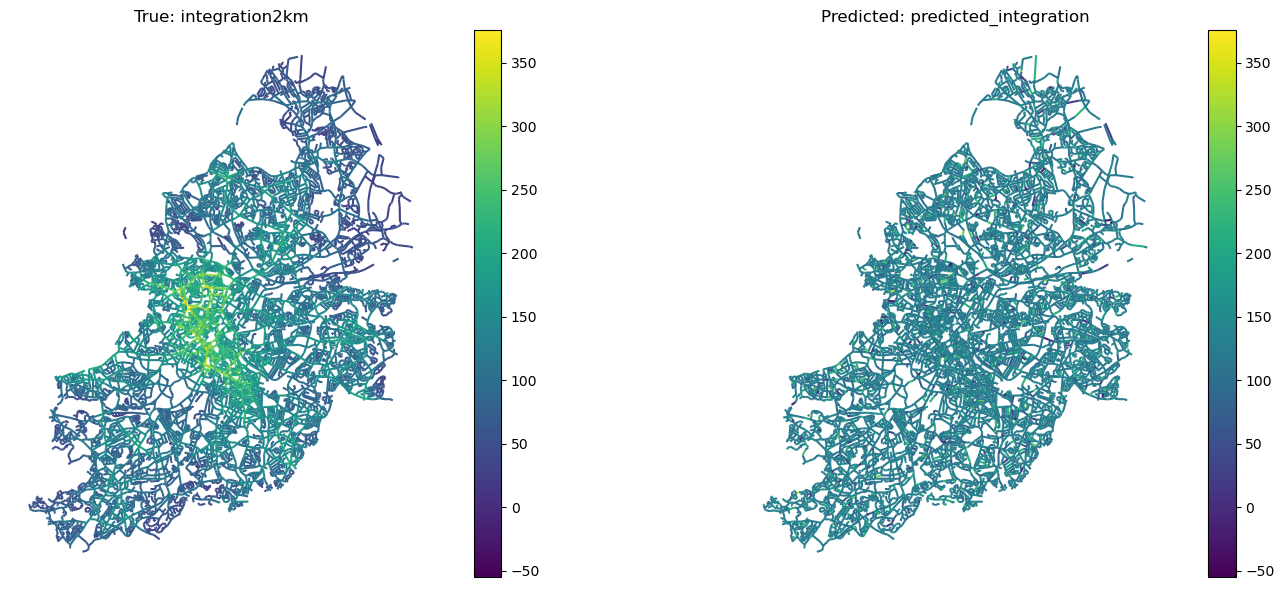

In [64]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def compare_predictions(dataframe, location, true_col, pred_col, geometry_col='wkt', crs='EPSG:27700'):
    # Convert to GeoDataFrame if not already
    #dataframe = dataframe[dataframe['lad11nm'] == location]
    gs = gpd.GeoSeries.from_wkt(dataframe[geometry_col])
    gdf = gpd.GeoDataFrame(dataframe, geometry=gs, crs=crs)

    # Determine common color scale
    vmin = min(gdf[true_col].min(), gdf[pred_col].min())
    vmax = max(gdf[true_col].max(), gdf[pred_col].max())

    norm = Normalize(vmin=vmin, vmax=vmax)

    # Plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    gdf.plot(column=true_col, cmap='viridis', legend=True, ax=axes[0], norm=norm)
    axes[0].set_title(f"True: {true_col}")
    axes[0].axis('off')

    gdf.plot(column=pred_col, cmap='viridis', legend=True, ax=axes[1], norm=norm)
    axes[1].set_title(f"Predicted: {pred_col}")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

model.eval()
with torch.no_grad():
    data.edge_index = edge_index  # use full edge list
    all_pred_weights, _ = model(data)

# Now `all_pred_weights` will have same length as total edges (same as df rows)
df['predicted_integration'] = all_pred_weights.detach().cpu().numpy()

base_path = r"C:\Users\chalm\Documents\Sem 2\Computational Intelligence\SpaceSyntax_UK\csv"
output_path = os.path.join(base_path, "london_predicted.csv")
df.to_csv(output_path, index=False)

# Then visualize side-by-side maps:
compare_predictions(df, 'london_combined', true_col='integration2km', pred_col='predicted_integration')
